In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

Given Differential equation,

$$\frac{d^2y}{dx^2} + \pi^2 \sin(\pi x) = 0$$

The boundary conditions are,
$$y(-1) = y(1) = 0$$

The exact solution is,
$$y(x) = \sin(\pi x)$$

In [2]:
def exact_sol(x):
    return torch.sin(np.pi*x)

In [3]:
class PinnModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=1, out_features=100)
        self.tanh = nn.Tanh()
        self.layer2 = nn.Linear(in_features=100, out_features=1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.tanh(out)
        out = self.layer2(out)
        return out


In [4]:
torch.manual_seed(42)
pinn = PinnModel()
x_test = torch.linspace(-1, 1, 300).view(-1, 1)
y_exact = exact_sol(x_test)

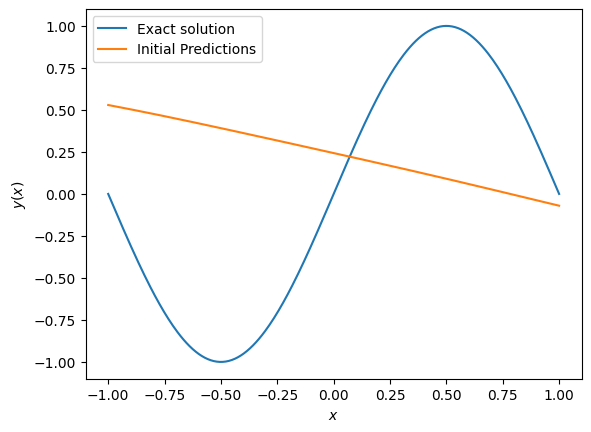

In [5]:
y_preds_initial = pinn(x_test)
plt.plot(x_test.squeeze(), y_exact.detach()[:,0], label="Exact solution")
plt.plot(x_test.squeeze(), y_preds_initial.detach()[:,0], label="Initial Predictions")
plt.xlabel("$x$")
plt.ylabel("$y(x)$")
plt.legend()
plt.show()

Training step: 0
Loss = 48.093570709228516 | Physics_loss = 47.80857467651367 | Boundary_loss = 0.2849941849708557


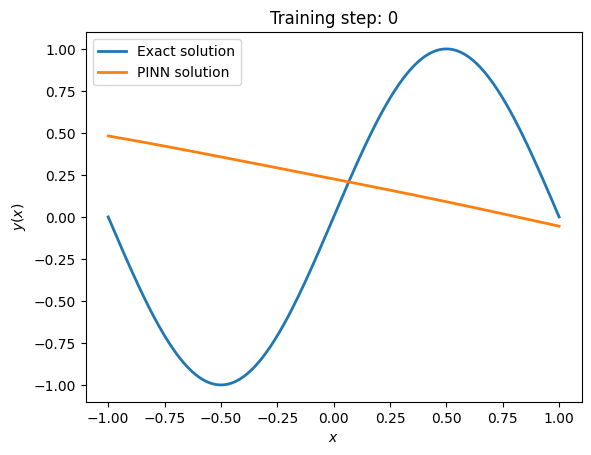

Training step: 200
Loss = 12.08388900756836 | Physics_loss = 11.934575080871582 | Boundary_loss = 0.1493137776851654


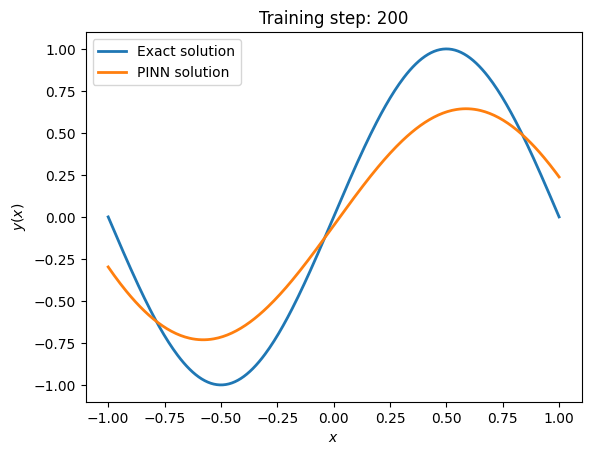

Training step: 400
Loss = 0.7806183695793152 | Physics_loss = 0.7759069204330444 | Boundary_loss = 0.004711468704044819


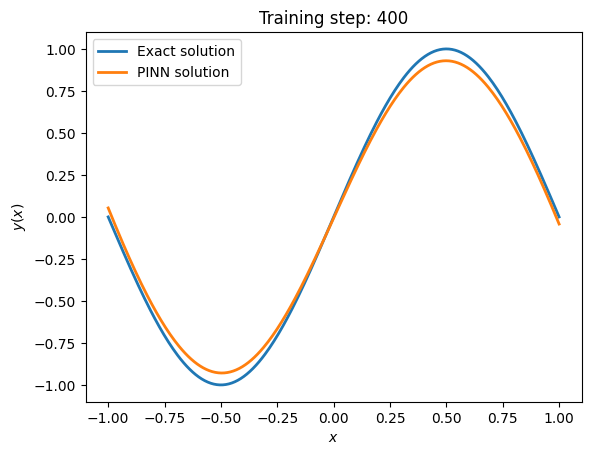

Training step: 600
Loss = 0.259552925825119 | Physics_loss = 0.259098082780838 | Boundary_loss = 0.00045483600115403533


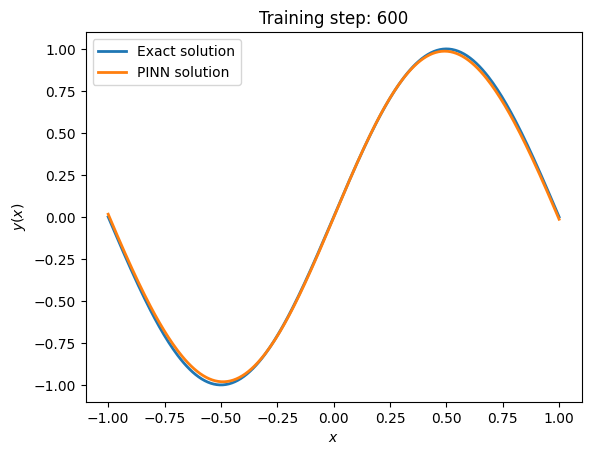

Training step: 800
Loss = 0.20156873762607574 | Physics_loss = 0.20132063329219818 | Boundary_loss = 0.000248100608587265


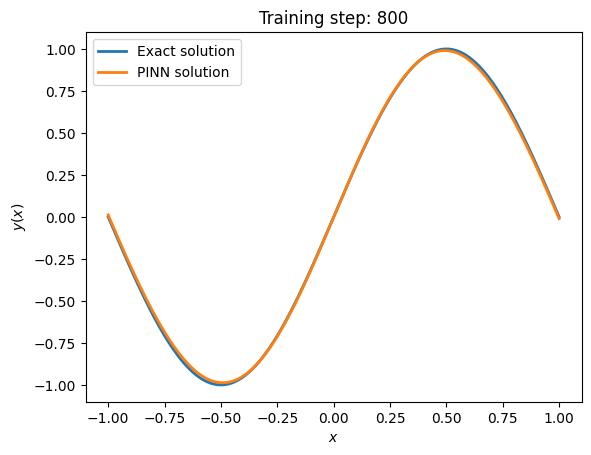

Training step: 1000
Loss = 0.15461210906505585 | Physics_loss = 0.1544295847415924 | Boundary_loss = 0.00018252446898259223


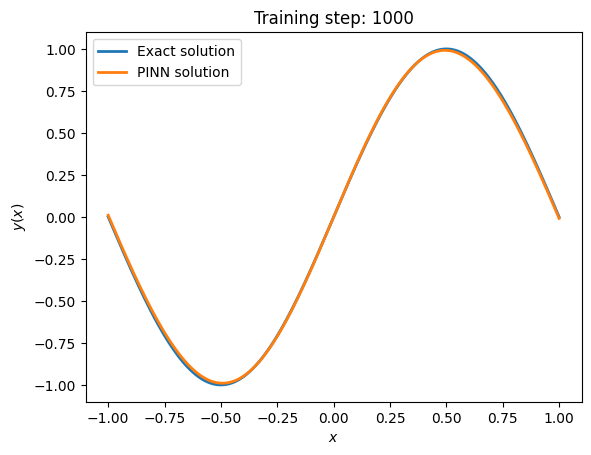

Training step: 1200
Loss = 0.11395370960235596 | Physics_loss = 0.11382199078798294 | Boundary_loss = 0.00013171907630749047


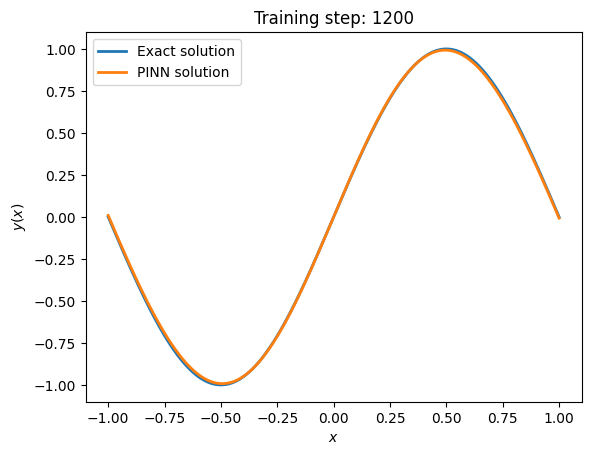

Training step: 1400
Loss = 0.0801704153418541 | Physics_loss = 0.08008137345314026 | Boundary_loss = 8.904404239729047e-05


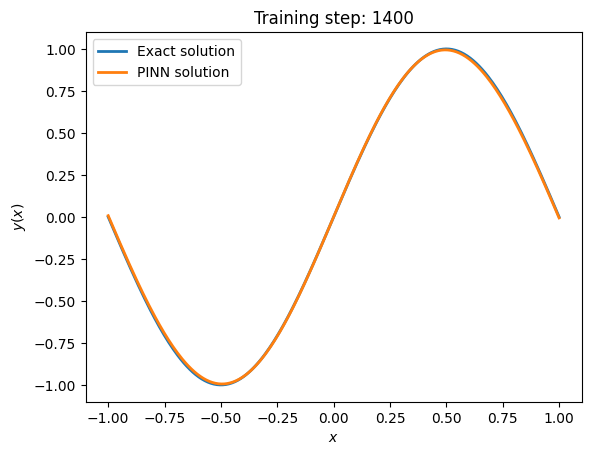

Training step: 1600
Loss = 0.05323876440525055 | Physics_loss = 0.053181856870651245 | Boundary_loss = 5.6907178077381104e-05


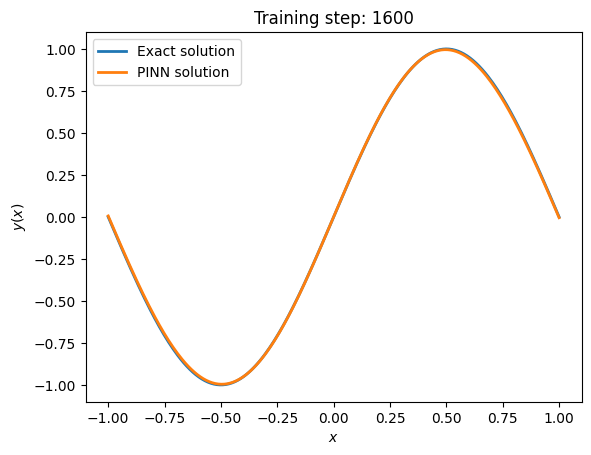

Training step: 1800
Loss = 0.03251730650663376 | Physics_loss = 0.032483626157045364 | Boundary_loss = 3.368039688211866e-05


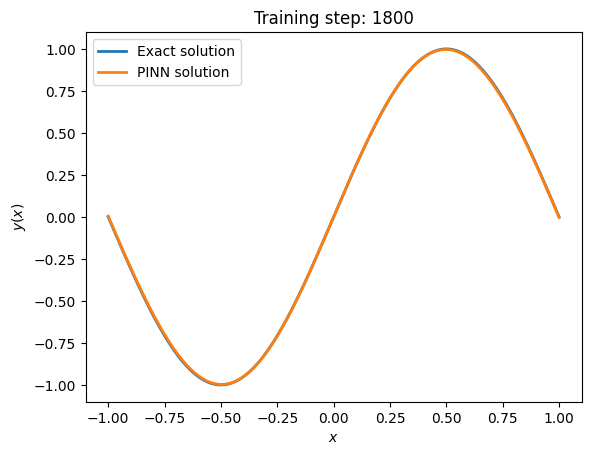

Training step: 2000
Loss = 0.018389690667390823 | Physics_loss = 0.018373455852270126 | Boundary_loss = 1.6235375369433314e-05


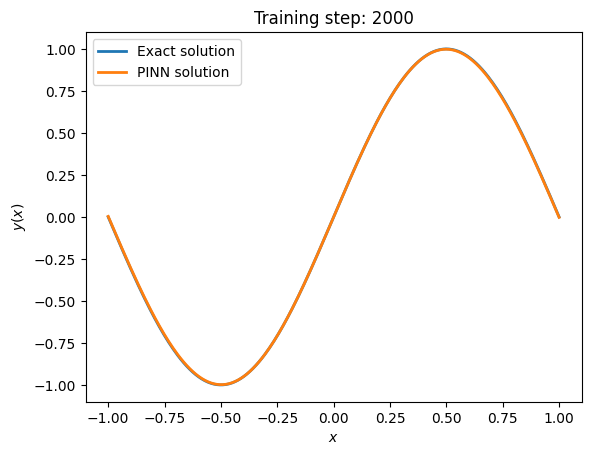

In [6]:
torch.manual_seed(42)
pinn = PinnModel()

x_boundary1 = torch.tensor(-1.0, requires_grad=True).view(-1, 1)
x_boundary2 = torch.tensor(1.0, requires_grad=True).view(-1, 1)

x_physics = torch.linspace(-1, 1, 50, requires_grad=True).view(-1, 1)

optimiser = torch.optim.Adam(pinn.parameters(), lr=0.001)
epochs = 2001

for i in range(epochs):
    optimiser.zero_grad()

    # Boundary loss
    y1 = pinn(x_boundary1)
    loss1 = (torch.squeeze(y1) - 0)**2
    y2 = pinn(x_boundary2)
    loss2 = (torch.squeeze(y2) - 0)**2

    # Physics loss
    y = pinn(x_physics)
    dy_dx = torch.autograd.grad(y, x_physics, torch.ones_like(y), create_graph=True)[0]
    d2y_dx2 = torch.autograd.grad(dy_dx, x_physics, torch.ones_like(dy_dx), create_graph=True)[0]
    loss3 = torch.mean((d2y_dx2 + (np.pi**2)*torch.sin(np.pi*x_physics))**2)

    # Total loss
    loss = loss1 + loss2 + loss3
    loss.backward()
    optimiser.step()

    if i % 200 == 0:
        print(f"Training step: {i}")
        print(f"Loss = {loss} | Physics_loss = {loss3} | Boundary_loss = {loss1 + loss2}")
        y = pinn(x_test)
        plt.plot(x_test.squeeze(), y_exact.detach()[:,0], label="Exact solution", linewidth=2)
        plt.plot(x_test.squeeze(), y.detach()[:,0], label="PINN solution", linewidth=2)
        plt.xlabel("$x$")
        plt.ylabel("$y(x)$")
        plt.title(f"Training step: {i}")
        plt.legend()
        plt.show()

# Inverse PINN

Given Differential equation,

$$\frac{d^2y}{dx^2} + k^2 \sin(kx) = 0$$

Our goal is to find $k$ value using Inverse PINN given the data points 

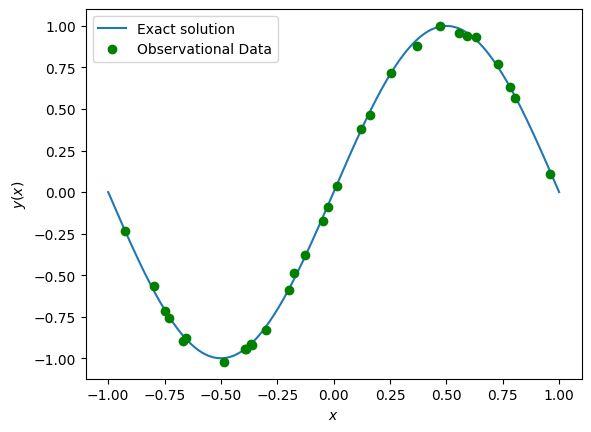

In [12]:
x_obs = 2 * torch.rand(30, 1) - 1
y_obs = exact_sol(x_obs) + 0.02 * torch.randn_like(x_obs)
plt.plot(x_test.squeeze(), y_exact.detach()[:,0], label="Exact solution")
plt.plot(x_obs.squeeze(), y_obs.detach()[:,0], 'og', label="Observational Data")
plt.xlabel("$x$")
plt.ylabel("$y(x)$")
plt.legend()
plt.show()

Training step: 0
Loss = 0.8582030534744263 | Data_loss = 0.8532686233520508 | Physics_loss = 0.004934428725391626 


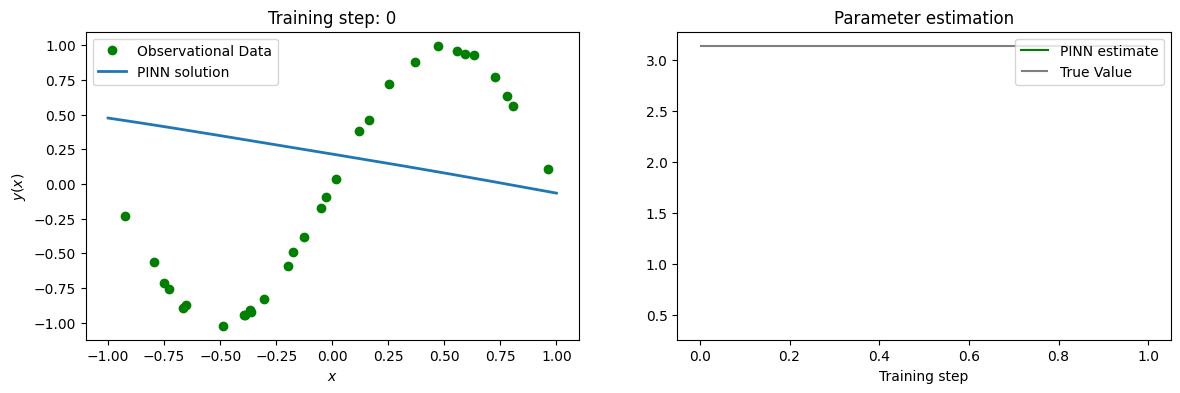

Training step: 1000
Loss = 0.14473387598991394 | Data_loss = 0.14363667368888855 | Physics_loss = 0.001097202766686678 


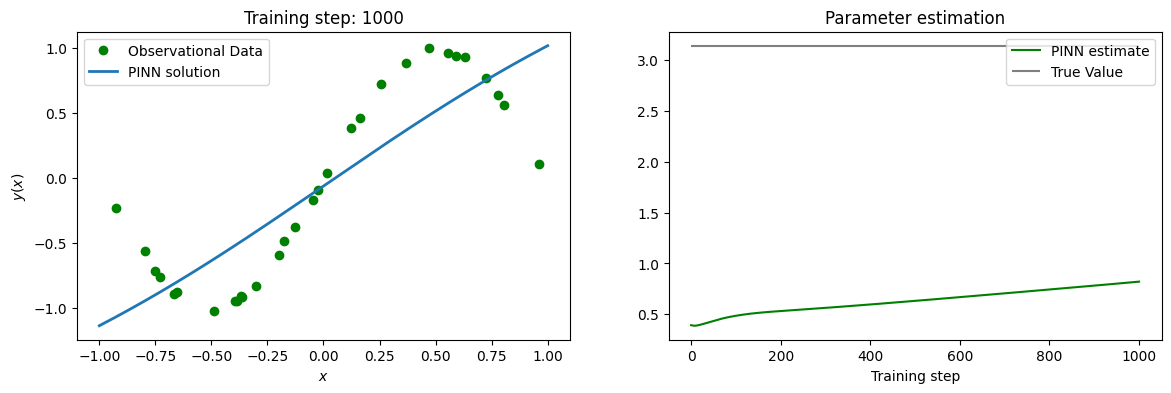

Training step: 2000
Loss = 0.11175072938203812 | Data_loss = 0.10873055458068848 | Physics_loss = 0.0030201745685189962 


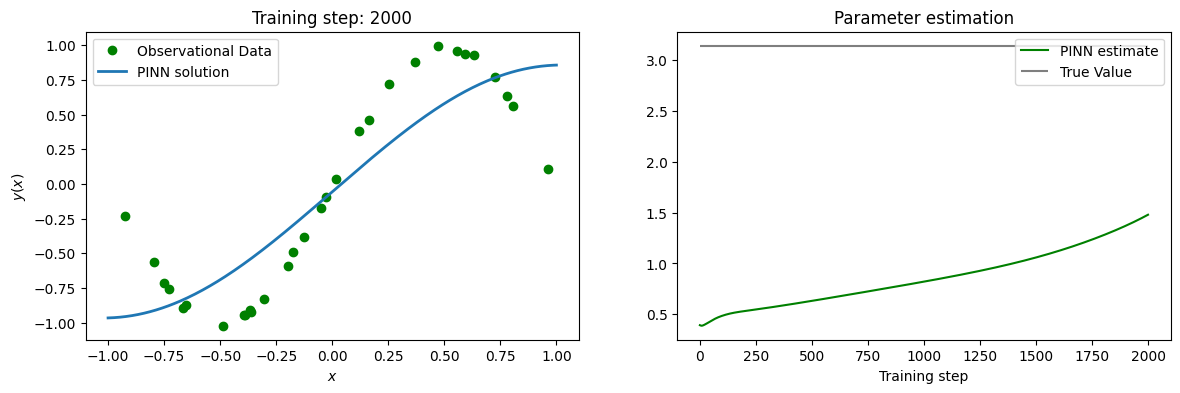

Training step: 3000
Loss = 0.006488570477813482 | Data_loss = 0.005680928006768227 | Physics_loss = 0.0008076425874605775 


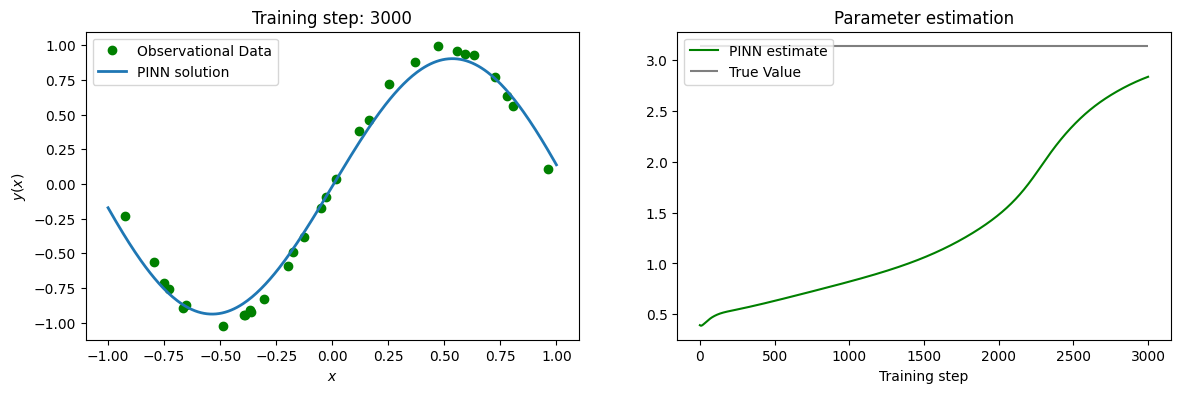

Training step: 4000
Loss = 0.0005366884870454669 | Data_loss = 0.00035736325662583113 | Physics_loss = 0.00017932523041963577 


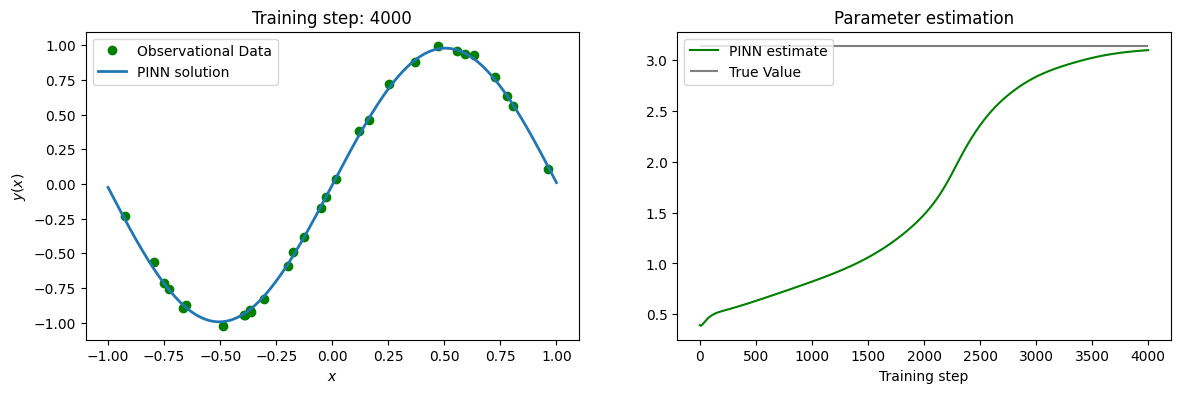

Training step: 5000
Loss = 0.00032256406848318875 | Data_loss = 0.0002605596382636577 | Physics_loss = 6.200442294357345e-05 


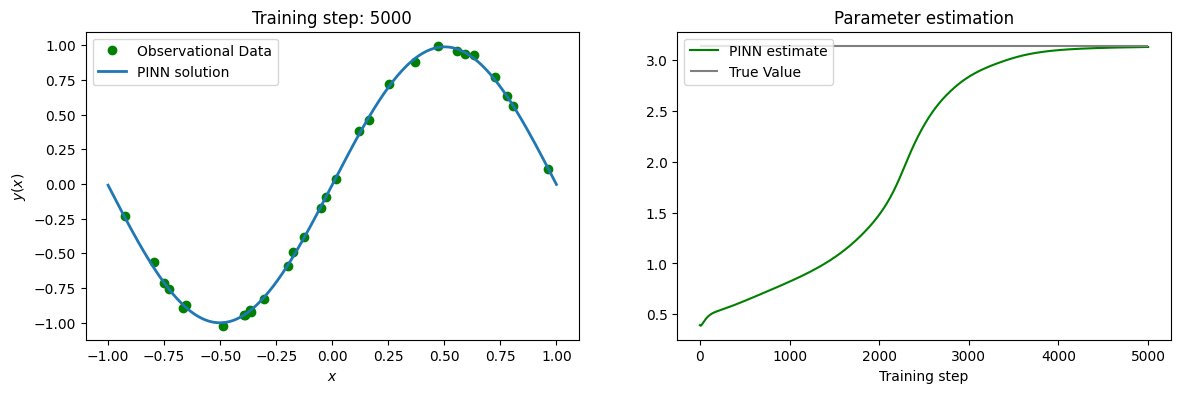

Training step: 6000
Loss = 0.0002974812814500183 | Data_loss = 0.0002553485974203795 | Physics_loss = 4.213268402963877e-05 


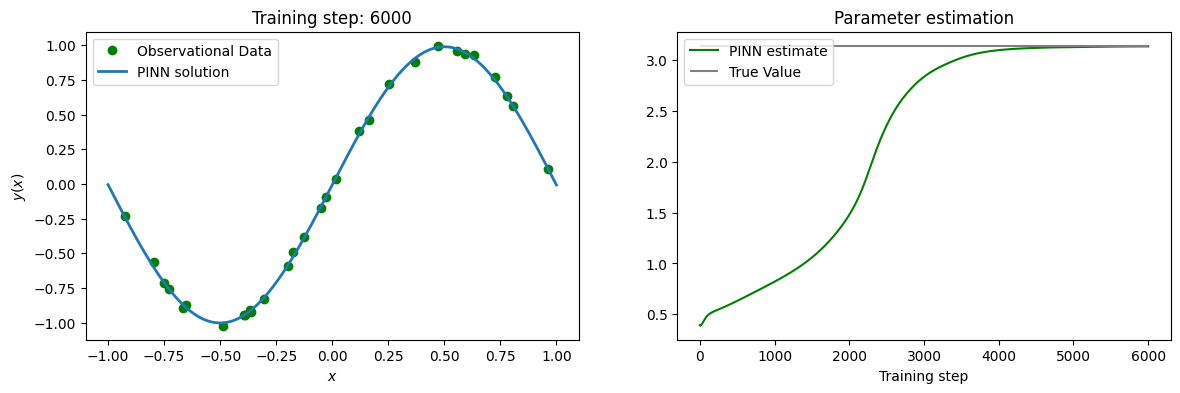

Training step: 7000
Loss = 0.000288041599560529 | Data_loss = 0.00025493765133433044 | Physics_loss = 3.310395550215617e-05 


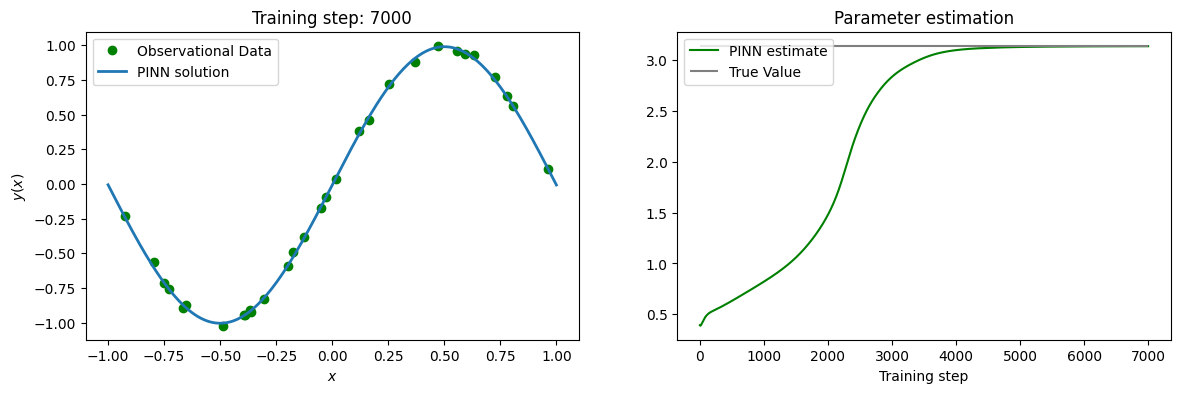

Training step: 8000
Loss = 0.00028213730547577143 | Data_loss = 0.0002540212881285697 | Physics_loss = 2.811601007124409e-05 


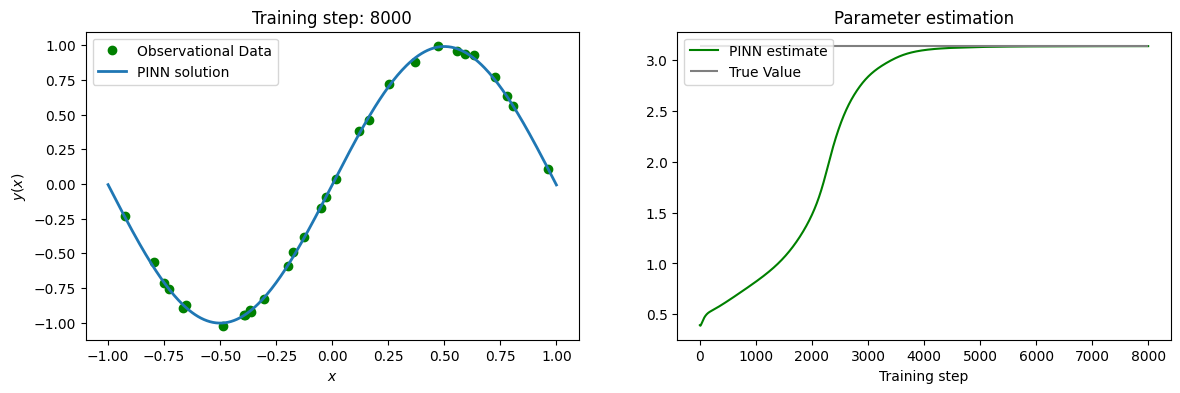

Training step: 9000
Loss = 0.00027883751317858696 | Data_loss = 0.0002539405832067132 | Physics_loss = 2.4896939066820778e-05 


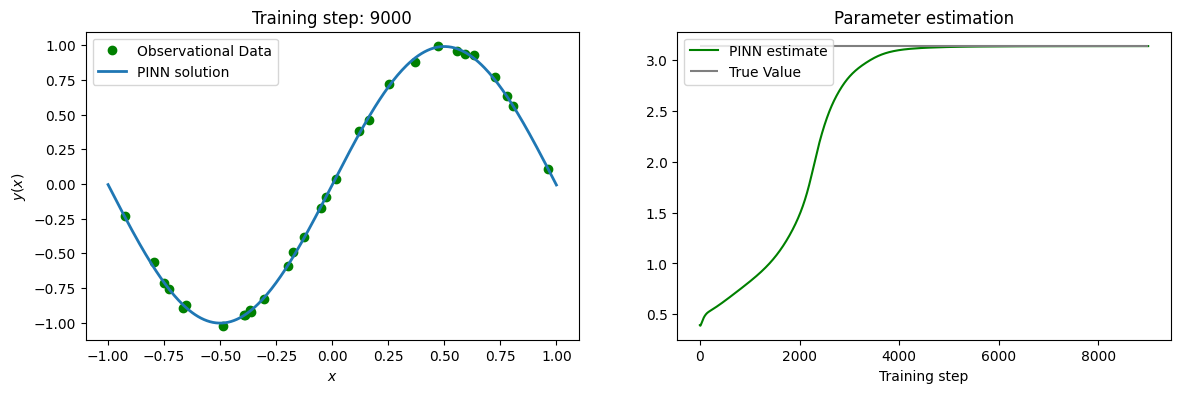

Training step: 10000
Loss = 0.00027581583708524704 | Data_loss = 0.0002537750406190753 | Physics_loss = 2.204078555223532e-05 


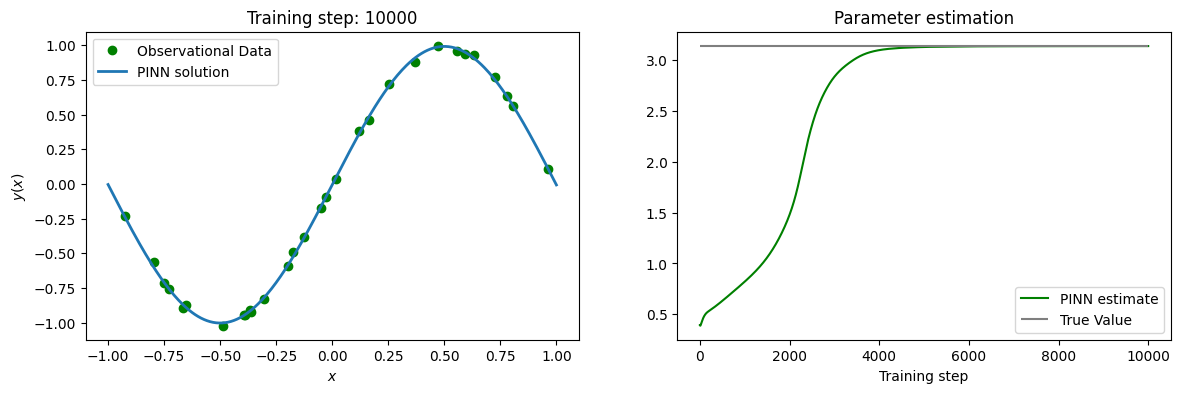

In [ ]:
torch.manual_seed(42)
pinn = PinnModel()

x_physics = torch.linspace(-1, 1, 50, requires_grad=True).view(-1, 1)

p = torch.nn.Parameter(torch.rand(1, requires_grad=True))
optimiser = torch.optim.Adam(list(pinn.parameters()) + [p], lr=0.001)
epochs = 10001
ps = []

for i in range(epochs):
    optimiser.zero_grad()

    # Data loss
    y = pinn(x_obs)
    loss1 = torch.mean((y - y_obs)**2)

    # Physics loss
    y = pinn(x_physics)
    dy_dx = torch.autograd.grad(y, x_physics, torch.ones_like(y), create_graph=True)[0]
    d2y_dx2 = torch.autograd.grad(dy_dx, x_physics, torch.ones_like(dy_dx), create_graph=True)[0]
    loss2 = torch.mean((d2y_dx2 + (p**2)*torch.sin(p*x_physics))**2)


    # Total loss
    loss = loss1 + loss2
    loss.backward()
    optimiser.step()

    ps.append(p.item())

    if i % 1000 == 0:
        print(f"Training step: {i}")
        print(f"Loss = {loss} | Data_loss = {loss1} | Physics_loss = {loss2} ")
        y = pinn(x_test)

        plt.figure(figsize=(14,4))
        plt.subplot(121)
        plt.plot(x_obs.squeeze(), y_obs.detach()[:,0], 'og', label="Observational Data")
        plt.plot(x_test.squeeze(), y.detach()[:,0], label="PINN solution", linewidth=2)
        plt.xlabel("$x$")
        plt.ylabel("$y(x)$")
        plt.title(f"Training step: {i}")
        plt.legend()

        plt.subplot(122)
        plt.plot(ps, label="PINN estimate", c='green')
        plt.hlines(np.pi, 0, len(ps), color="tab:grey", label="True Value")
        plt.title("Parameter estimation")
        plt.xlabel("Training step")
        plt.legend()
        plt.show()